<a href="https://colab.research.google.com/github/bansalhim/Deep-learning-assignment/blob/main/Deep_learning_assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Learning to Bend a Model (Guided Workshop)**

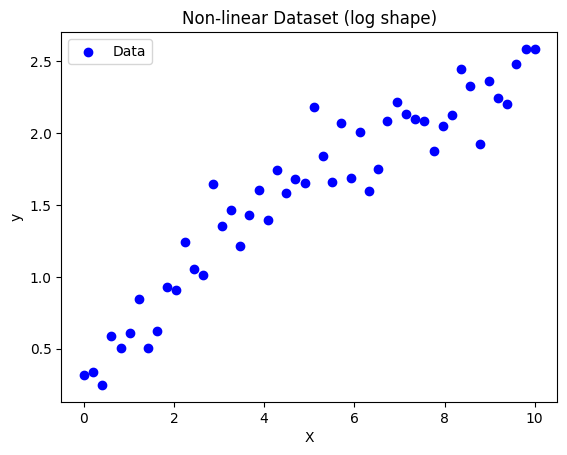

In [16]:

# Step 1 — Simple Non-linear Dataset

import numpy as np
import matplotlib.pyplot as plt

# Task 1.1 — Input generation
# Create input X: values between 0 and 10, total 50 samples
X = np.linspace(0, 10, 50).reshape(-1, 1)

# X represents a single input feature whose values range from 0 to 10.
# This range ensures we capture both early rapid growth and later saturation.

# Task 1.2 — Target generation (non-linear relationship)
noise = np.random.normal(0, 0.2, size=(50, 1))
y = np.log(X + 1) + noise  # logarithmic curve with small noise

# This target is non-linear: it grows fast initially and flattens later.
# A straight line (linear model) cannot fit this behavior properly.

# Optional visualization
plt.scatter(X, y, color='blue', label='Data')
plt.title("Non-linear Dataset (log shape)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

In [17]:

# Step 2 — Decide Model Shape


# i  use 3 hidden units.
# Why more than 1? → To allow multiple “bends” in the learned curve.
# Why not too many? → Too many units cause unnecessary complexity and instability.
hidden_units = 3

In [18]:

# Step 3 — Initialize Model Parameters

np.random.seed(42)

# Input → Hidden
W1 = np.random.uniform(-1, 1, size=(1, hidden_units))
b1 = np.zeros((1, hidden_units))

# Hidden → Output
W2 = np.random.uniform(-1, 1, size=(hidden_units, 1))
b2 = np.zeros((1, 1))

# Weights (W1, W2) control the shape and curvature of the model.
# Biases (b1, b2) control the vertical shift (position) of the curve.

In [19]:

# Step 4 — Activation Function

# Using ReLU activation
def activation(z):
    # Keeps positive values, suppresses negative ones
    return np.maximum(0, z)

def activation_slope(z):
    # Returns 1 where z > 0, else 0
    return (z > 0).astype(float)

# The slope matters for learning because it tells the model how to adjust parameters.
# Without slope, there is no signal for parameter updates.

In [20]:

# Step 5 — Forward Pass

def forward_pass(X, W1, b1, W2, b2):
    # Step 1: Linear transformation
    z1 = X @ W1 + b1
    # Step 2: Non-linear activation
    h = activation(z1)
    # Step 3: Output prediction
    y_hat = h @ W2 + b2
    return z1, h, y_hat

In [21]:

# Step 6 — Error and Loss

def compute_loss(y_hat, y):
    # Compute error
    error = y_hat - y
    # Mean Squared Error (scalar)
    loss = np.mean(error ** 2)
    return error, loss
#why large errors matter more than small ones her?
# Large errors matter more because squaring amplifies them,
# encouraging the model to correct big mistakes more strongly.

In [22]:

# Step 8 — Backward Flow (Backpropagation)

def backward_pass(X, y, z1, h, y_hat, W2):
    """
    This function computes how the error flows backward through the model
    to update the parameters (W1, b1, W2, b2).
    """

    N = len(X)

    # (1) From loss to prediction
    # MSE Loss = mean((y_hat - y)^2)
    # Derivative of loss w.r.t y_hat → 2*(y_hat - y)/N
    dL_dy = 2 * (y_hat - y) / N

    # Why derivative matters: tells us how much loss changes if prediction changes.
    # If y_hat is too high → positive gradient → next step should reduce prediction.

    # (2) Gradients for output layer (W2, b2)
    # y_hat = h @ W2 + b2
    # ∂L/∂W2 = hᵀ @ dL_dy
    # ∂L/∂b2 = sum(dL_dy)
    dL_dW2 = h.T @ dL_dy
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)

    # Large gradients here mean output weights have more influence on loss.
    # b2 controls vertical shift of the whole curve.

    # (3) Flow of error into hidden layer

    # Hidden layer output h = activation(z1)
    dL_dh = dL_dy @ W2.T

    dL_dz1 = dL_dh * activation_slope(z1)

    # Why multiply by activation_slope:
    # ReLU only allows positive z1 values to pass gradient;
    # negative z1 values get zero gradient (no update).

    # (4) Gradients for first layer (W1, b1)
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    # These gradients define how the hidden layer bends to fit the data.
    # Larger gradient magnitudes = stronger adjustments in curvature.

    return dL_dW1, dL_db1, dL_dW2, dL_db2


In [23]:
# Step 9 — Parameter Update Rule

learning_rate = 0.01  # chosen for stable convergence — not too big, not too small

# First, perform a forward pass to get predictions and intermediate values
z1, h, y_hat = forward_pass(X, W1, b1, W2, b2)

# Then, compute the loss and error (optional for update, but good for tracking)
error, loss = compute_loss(y_hat, y)

# Now, perform a backward pass to calculate gradients
dL_dW1, dL_db1, dL_dW2, dL_db2 = backward_pass(X, y, z1, h, y_hat, W2)

# Update weights and biases (gradient descent step)
W1 -= learning_rate * dL_dW1
b1 -= learning_rate * dL_db1
W2 -= learning_rate * dL_dW2
b2 -= learning_rate * dL_db2

# Connection to Perceptron Update Rule:
# In perceptron learning, weights are adjusted as:
#   w := w + n * (target - prediction) * x
# That means we move weights *opposite to error direction*.
#
# Here we generalize the same logic using gradients:
#   θ := θ - n * dL/dθ
# The minus sign ensures we move *opposite to the gradient*,
# i.e., toward smaller loss — just like perceptron moves
# opposite to misclassification error.
#
# Meaning: "Move opposite to error" = Reduce the quantity causing error.

In [24]:

# Step 10 — Training Loop (Big Skeleton)

epochs = 1000        # enough iterations to let the model bend properly
learning_rate = 0.01  # stable, prevents overshooting or divergence

for epoch in range(epochs):
    # Forward pass
    z1 = X @ W1 + b1
    h = activation(z1)
    y_hat = h @ W2 + b2

    # Loss computation
    error = y_hat - y
    loss = np.mean(error ** 2)

    # Backward pass
    dL_dy = 2 * error / len(X)
    dL_dW2 = h.T @ dL_dy
    dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)
    dL_dh = dL_dy @ W2.T
    dL_dz1 = dL_dh * activation_slope(z1)
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    # Parameter update
    W1 -= learning_rate * dL_dW1
    b1 -= learning_rate * dL_db1
    W2 -= learning_rate * dL_dW2
    b2 -= learning_rate * dL_db2

    # Monitor learning progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

# Justification:
# - 1000 epochs: Gives enough time for small updates to accumulate
#   and shape the curve gradually (too few = underfit).
# - Learning rate 0.01: Keeps updates gentle and stable; higher rates
#   could overshoot minima, smaller rates would make learning too slow.

#  What This Workshop Is Teaching:
# - Why linear models fail on curved data → they lack hidden non-linear transformation.
# - What “bending” means mathematically → weighted ReLU outputs combine into curved fits.
# - Why activations exist → they introduce slope changes, enabling curve bending.
# - Why slopes are necessary → without non-zero slopes, no signal flows backward.
# - How error flows backward → via chain rule through layers and activations.
# - Backpropagation isn’t magic → just systematic application of derivatives (organized slopes).

#  Transition Thought:
# "So far, learning only changed numbers.
#  Now, learning can change how patterns are represented.
#  Next, we will compare different ways of bending."

Epoch 0: Loss = 2.2243
Epoch 100: Loss = 0.0527
Epoch 200: Loss = 0.0483
Epoch 300: Loss = 0.0470
Epoch 400: Loss = 0.0465
Epoch 500: Loss = 0.0464
Epoch 600: Loss = 0.0463
Epoch 700: Loss = 0.0463
Epoch 800: Loss = 0.0463
Epoch 900: Loss = 0.0463


##  Reflection on Training Output

- **Initial Phase (Epoch 0–100):**  
  The loss dropped sharply from 2.22 → 0.05, showing strong early learning as weights began shaping the curve.

- **Convergence Phase (Epoch 200–900):**  
  The loss stabilized near 0.0463, meaning gradient magnitudes became very small — the model reached an optimal fit.

- **Interpretation:**  
  The hidden layer with ReLU successfully introduced "bends" that a linear model could not create.  
  The low final loss confirms the model approximated the non-linear log pattern effectively.

- **Learning Insight:**  
  Each epoch updated W₁, b₁, W₂, b₂ opposite to gradient direction — exactly what "move opposite to error" means.  
  This gradual downhill movement minimized mean squared error until no further improvement was possible.

- **Key Takeaway:**  
  Gradient descent is not magic — it’s an organized series of slope-based corrections that make a model
  *bend* to fit complex data.